In [31]:
import numpy as np
import networkx as nx
import random
import warnings
import matplotlib.pyplot as plt
import pandas as pd

#解决中文显示问题
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
warnings.filterwarnings("ignore")


In [2]:
import os

def excel_writer(file_name, sheetname, df):
    """
    参数:
    file_name : 存储df的excel文件名
    sheetname ：excel文件中用于存df的那个sheet的名字
    df        : 要写入excel的dataframe
    """
    if not os.path.exists(file_name):
        writer = pd.ExcelWriter(file_name)
    else:
        writer = pd.ExcelWriter(file_name, mode='a', engine="openpyxl")
    df.to_excel(writer, sheet_name=sheetname, encoding='gbk', index=False)
    writer.save()
    print('DataFrame is written successfully to the Excel File.')


In [3]:
"""准备公式"""
def get_mt(ticks):
    '''parm1:当前ticks'''
    '''parm2:sizeof辟谣规模'''
    '''return:辟谣影响规模'''
    if ticks<tau:
        return 0
    return m

'''susceptible'''
def get_p03(n_3):
    '''parm1:邻居节点muzzled数量'''
    '''parm2:邻居节点rumor数量'''
    '''return:被rumor影响的概率'''
    return 1- ((1-q_03)**n_3)

def get_p01(ticks,n_1):
    '''parm1:当前ticks'''
    '''parm2:邻居节点rebuttal-infected数量'''
    '''return:被辟谣影响的概率'''
    mt = get_mt(ticks)
    return 1 - (1-mt)* ((1-q_01)**n_1)

def get_alpha(ticks,n_1,n_3):
    '''return:比重'''
    if (get_p03(n_3)==0) and (get_p01(ticks,n_1)==0):
        return 0
    return get_p03(n_3)/(get_p03(n_3) + get_p01(ticks,n_1))

'''rumor'''
def get_p31(ticks,n_1):
    ''':param1 邻居节点rebuttal-infected数量'''
    ''':return 节点被rebuttal-infected影响的概率'''
    mt = get_mt(ticks)
    return 1-(1-mt)*((1-q_31)**n_1)

def get_p32(n_3):
    ''':param1 邻居节点muzzled数量'''
    ''':return 被muzzled影响的概率'''
    return 1-((1-q_33)**n_3)

def get_beta(ticks,n_1,n_3):
    ''':return 比重'''
    if (get_p32(n_3)==0 and get_p31(ticks,n_1) == 0):
        return 0
    return get_p32(n_3)/(get_p32(n_3)+get_p31(ticks,n_1))

'''muzzled'''
def get_p21(ticks,n_1):
    ''':return 被rebutta-infected影响的概率'''
    mt = get_mt(ticks)
    return 1-(1-mt)*((1-q_21)**n_1)

def get_p23(n_3):
    ''':return  被rumor影响概率'''
    return  1-(1-q_23)**n_3

def get_gamma(ticks,n_1,n_3):
    ''':return 比重'''
    if (get_p23(n_3)==0 and get_p21(ticks,n_1) == 0):
        return 0
    return get_p23(n_3)/(get_p23(n_3)+get_p21(ticks,n_1))


In [4]:
"""计算公式"""
'''susceptible'''
def get_0to3(ticks, n_1,n_3):
    '''return:易感成为rumor-infected概率'''
    return get_p03(n_3) * (1 - get_p01(ticks, n_1)) + get_alpha(ticks, n_1, n_3) * get_p03(n_3) * get_p01(ticks, n_1)

def get_0to1(ticks, n_1, n_3):
    '''return:易感成为rebuttal-infected概率'''
    if (get_p03(n_3)==0 and get_p01(ticks,n_1)==0):
        return get_p01(ticks, n_1) * (1 - get_p03(n_3))
    return get_p01(ticks, n_1) * (1 - get_p03(n_3)) + (1 - get_alpha(ticks, n_1, n_3)) * get_p03(n_3) * get_p01(ticks, n_1)

'''rumor'''
def get_3to2(ticks,n_1,n_3):
    ''':return  rumor成为muzzled的概率'''
    return get_p32(n_3)*(1-get_p31(ticks,n_1)) + get_beta(ticks,n_1,n_3)*get_p32(n_3)*get_p31(ticks,n_1)

def get_3to1(ticks,n_1,n_3):
    ''':return rumor成为rebuttal-infected概率'''
    if (get_p32(n_3)==0 and get_p31(ticks,n_1) == 0):
        return (1-get_p32(n_3))*get_p31(ticks,n_1)
    return (1-get_p32(n_3))*get_p31(ticks,n_1) + (1-get_beta(ticks,n_1,n_3))*get_p32(n_3)*get_p31(ticks,n_1)

'''muzzled'''
def get_2to3(ticks,n_1,n_3):
    ''':return muzzled 成为 rumor 概率'''
    return get_p23(n_3)*(1-get_p21(ticks,n_1)) + get_gamma(ticks,n_1,n_3)*get_p23(n_3)*get_p21(ticks,n_1)

def get_2to1(ticks,n_1,n_3):
    ''':return muzzled 成为 rebuttal-infected概率'''
    if  (get_p23(n_3)==0 and get_p21(ticks,n_1) == 0):
        return  (1-get_p23(n_3))*get_p21(ticks,n_1)
    return (1-get_p23(n_3))*get_p21(ticks,n_1) + (1-get_gamma(ticks,n_1,n_3))*get_p23(n_3)*get_p21(ticks,n_1)



In [5]:

'''---------------------------------执行函数---------------------------------------------'''
def get_forget_rate(ticks, lamda, theta):
    '''parm1:t ticks'''
    '''parm2:遗忘系数'''
    '''parm3:theta ticks后rebuttal开始遗忘'''
    '''return:辟谣开始theta ticks后遗忘概率'''
    if (ticks - tau) > theta:
        return 1-np.exp(-0.1* lamda * (ticks - tau - theta))
    return 0

def get_neighbors_state(graph,node):
    num_Rebuttal_infected = 0
    num_muzzled = 0
    num_Rumor_infected = 0
    for temp in list(graph.neighbors(node)):
        if graph.nodes[temp]['status']== 'Rebuttal-infected':
            num_Rebuttal_infected+=1
        elif graph.nodes[temp]['status'] == 'muzzled':
            num_muzzled+=1
        elif graph.nodes[temp]['status'] == 'Rumor-infected':
            num_Rumor_infected +=1
    return num_Rebuttal_infected,num_muzzled,num_Rumor_infected


def update_node_status(graph, node, ticks):
    """
    更新节点状态
    :param graph: 网络图
    :param node: 节点序数
    """
    n_1, n_2, n_3 = get_neighbors_state(graph, node)
    if graph.nodes[node]['status'] == 'Susceptible':
        p = random.random()
        if p < get_0to3(ticks, n_1, n_3):
            # Susceptible到Rumor-infected
            graph.nodes[node]['status'] = 'Rumor-infected'
        elif p < get_0to3(ticks, n_1, n_3) + get_0to1(ticks, n_1, n_3):
            # Susceptible到Rebuttal-infected
            graph.nodes[node]['status'] = 'Rebuttal-infected'

    # muzzled
    elif graph.nodes[node]['status'] == 'muzzled':
        if(graph.nodes[node]['term'] ==0):
            p = random.random()
            if p < get_2to1(ticks, n_1, n_3):
                graph.nodes[node]['status'] = 'Rebuttal-infected'
            elif p < get_2to1(ticks, n_1, n_3) + get_2to3(ticks, n_1, n_3):
                graph.nodes[node]['status'] = 'Rumor-infected'
        else:
            graph.nodes[node]['term'] -= 1

    # Rumor-infected
    elif graph.nodes[node]['status'] == 'Rumor-infected':
        p = random.random()
        if p < get_3to1(ticks, n_1,n_3):
            graph.nodes[node]['status'] = 'Rebuttal-infected'
        elif p < get_3to1(ticks, n_1,n_3) + get_3to2(ticks,n_1,n_3):
            graph.nodes[node]['status'] = 'muzzled'

    return


def init_graph(graph, rumor_p):
    '''初始化图节点数据'''
    N = graph.number_of_nodes()
    nnode = int(N * rumor_p)

    for node in graph:
        graph.nodes[node]['status'] = 'Susceptible'
        graph.nodes[node]['term'] = freezedays

    for i in range(0, nnode):
        while (1):
            randn = random.randint(0, N - 1)
            if (graph.nodes[randn]['status'] == 'Susceptible'):
                graph.nodes[randn]['status'] = 'Rumor-infected'
                break
    return graph


def quit_iterator(ticks,graph):
    '''两种状态以一定概率退出系统'''
    for node in graph:
        if graph.nodes[node]['status'] == 'Rebuttal-infected':
            p = random.random()
            # rate = get_forget_rate(ticks,lamda,theta)
            # print(f'p:{p},forget_rate{rate}\n')
            if p < get_forget_rate(ticks,lamda,theta):
                graph.nodes[node]['status'] = 'Rebuttal-removed'
        elif graph.nodes[node]['status'] == 'muzzled':
            p = random.random()
            if p < get_forget_rate(ticks,lamda,theta):
                graph.nodes[node]['status'] = 'muzzled-removed'


def count_node(graph):
    """
    计算当前图内各个状态节点的数目
    :param graph: 输入图
    :return: 各个状态的节点数目
    """
    num_Rebuttal_infected = 0
    num_muzzled = 0
    num_Rumor_infected = 0

    num_R1_removed = 0
    num_R2_removed = 0


    for node in graph:
        if graph.nodes[node]['status'] == 'Rebuttal-infected':
            num_Rebuttal_infected += 1
        elif graph.nodes[node]['status'] == 'muzzled':
            num_muzzled += 1
        elif graph.nodes[node]['status'] == 'Rumor-infected':
            num_Rumor_infected += 1
        elif graph.nodes[node]['status'] == 'Rebuttal-removed':
            num_R1_removed += 1
        elif graph.nodes[node]['status'] == 'muzzled-removed':
            num_R2_removed += 1
    return num_Rebuttal_infected, num_muzzled, num_Rumor_infected, num_R1_removed, num_R2_removed,


def update_test_network(graph, ticks):
    n = graph.number_of_nodes()  # 网络节点个数
    # 开始迭代感染
    for node in graph:
        update_node_status(graph, node, ticks)  # 针对node号节点进行SIR过程
    quit_iterator(ticks,graph)
    n_1,n_2,n_3,re_n_1, re_n_2, = count_node(graph)  # 得到本次迭代结束后各个状态（S、I、R）的节点数目
    return n_1/n, n_2/n, n_3/n, re_n_1/n, re_n_2/n

def test_rounds_update(graph,ticks):
    myres = []
    mygraph = init_graph(graph,rumor_p)
    myres.append((0,0,0,0,0)) 
    for t in range(1,ticks+1):
        myres.append(update_test_network(mygraph, t))
    return myres


In [6]:
'''freeze不能对别人产生影响'''
'''禁言有可能导致谣言传播周期变长？'''
'''对比每个freezedays下的rumor变化'''
'''对比每个freezedays下的rebuttal变化'''
'''辟谣时间点、遗忘开始时间点、freezedays等因素下rumor和rebuttal峰值变化'''

samevalue = 0.05
q_01=samevalue
#q_02=samevalue*3
q_03=samevalue*3
q_23=samevalue
q_31=samevalue
q_32=samevalue
q_33=samevalue
q_21=samevalue
freezedays=1

tau=0   #辟谣时间点
ticks = 50
m = 0.02
num_nodes = 1000
rumor_p = 0.01
lamda =0.05
theta =0 #在辟谣后theta个ticks后遗忘开始

In [18]:
init_G = nx.complete_graph(11)
Barabasi_G = nx.barabasi_albert_graph(n=num_nodes, m=5, seed = 128, initial_graph = init_G)#无标度网络
graph = nx.convert_node_labels_to_integers(Barabasi_G, first_label=0, ordering='default', label_attribute=None)

In [7]:
list_days=[0,2,4,6,8,10,15,20]
t_iters=3

In [32]:
reslist=[]
for day in list_days:
    freezedays = day
    res = test_rounds_update(graph,ticks)
    for j in range(len(res[0])):
        temp=[t[j] for t in res]
        reslist.append(temp)
res_array = np.array(reslist)

for iters in range(t_iters-1):
    templist=[]
    for day in list_days:
        freezedays = day
        res = test_rounds_update(graph,ticks)
        for j in range(len(res[0])):
            temp=[t[j] for t in res]
            templist.append(temp)
    temp_array=np.array(templist)
    res_array =res_array+temp_array
    
res_array=res_array/t_iters
    


In [8]:
reslist = res_array.tolist()
name_list = [1,2,3,-1,-2]
index_list=[]
for day in list_days:
    for name in name_list:      
        index_str = '{}-{}'.format(name,day)
        index_list.append(index_str)
data=pd.DataFrame(reslist,index=index_list,columns=[i for i in range(0,51,1)])
excel_writer('output.xlsx',sheetname='Sheet3',df=data)

NameError: name 'res_array' is not defined

    reslist每一行为 day-name
    如前八行:0-rebuttal 2-rebuttal 4-rebuttal 6-rebuttal 8-rebuttal 10-rebuttal 15-rebuttal 20-rebuttal 

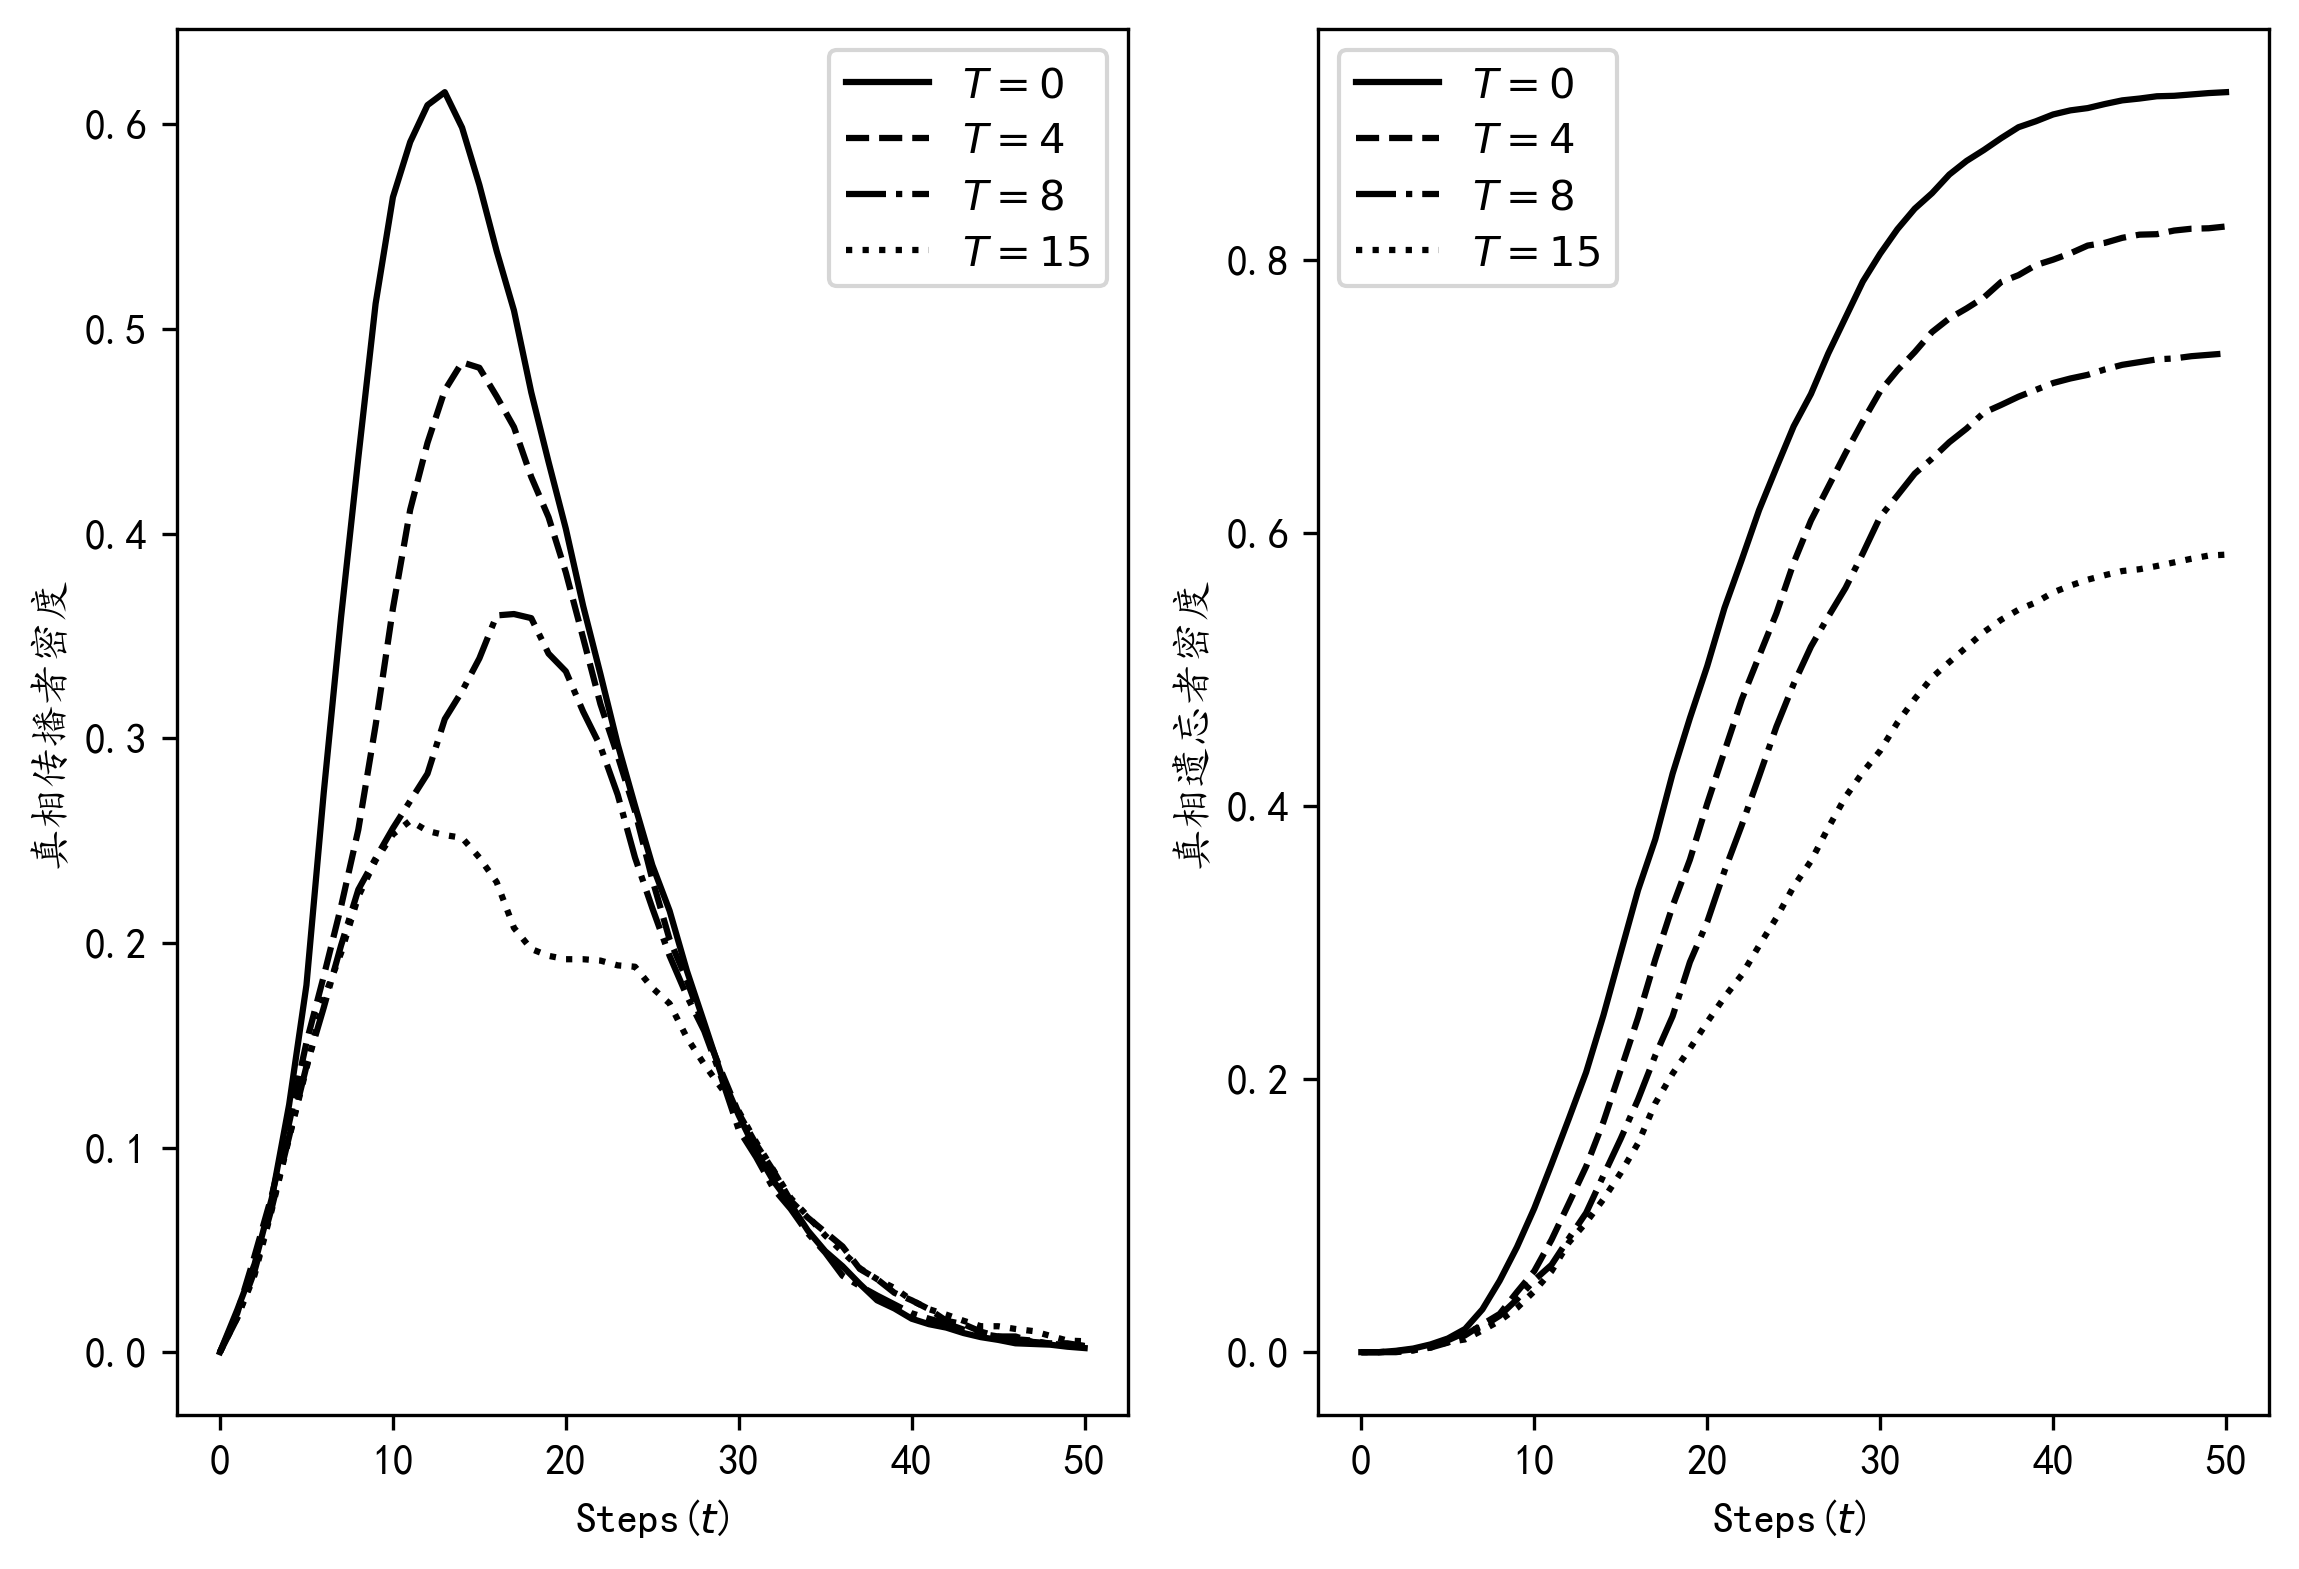

In [32]:
data=pd.read_excel("output.xlsx",sheet_name="Sheet3")
list_days=[0,2,4,6,8,10,15,20]
plt.figure(figsize=(9,6),dpi=300)
ax = plt.subplot(121)
xticks=[np.linspace(0,50,6)]
yticks=[np.linspace(0,0.9,10)]

plt.plot(range(51),data.iloc[0*5],color = 'k',linestyle='-',label='$T=0$')
plt.plot(range(51),data.iloc[2*5],color = 'k',linestyle='--',label='$T=4$')
plt.plot(range(51),data.iloc[4*5],color = 'k',linestyle='-.',label='$T=8$')
plt.plot(range(51),data.iloc[6*5],color = 'k',linestyle=':',label='$T=15$')
plt.legend()
plt.ylabel('真相传播者密度')
plt.xlabel('Steps($t$)')


ax = plt.subplot(122)
xticks=[np.linspace(0,50,6)]
yticks=[np.linspace(0,0.9,10)]

plt.plot(range(51),data.iloc[0*5+3],color = 'k',linestyle='-',label='$T=0$')
plt.plot(range(51),data.iloc[2*5+3],color = 'k',linestyle='--',label='$T=4$')
plt.plot(range(51),data.iloc[4*5+3],color = 'k',linestyle='-.',label='$T=8$')
plt.plot(range(51),data.iloc[6*5+3],color = 'k',linestyle=':',label='$T=15$')

plt.ylabel('真相遗忘者密度')
plt.xlabel('Steps($t$) ')


plt.legend()
plt.savefig('./paper/rebuttal对比图-黑白.png.png')
plt.show()

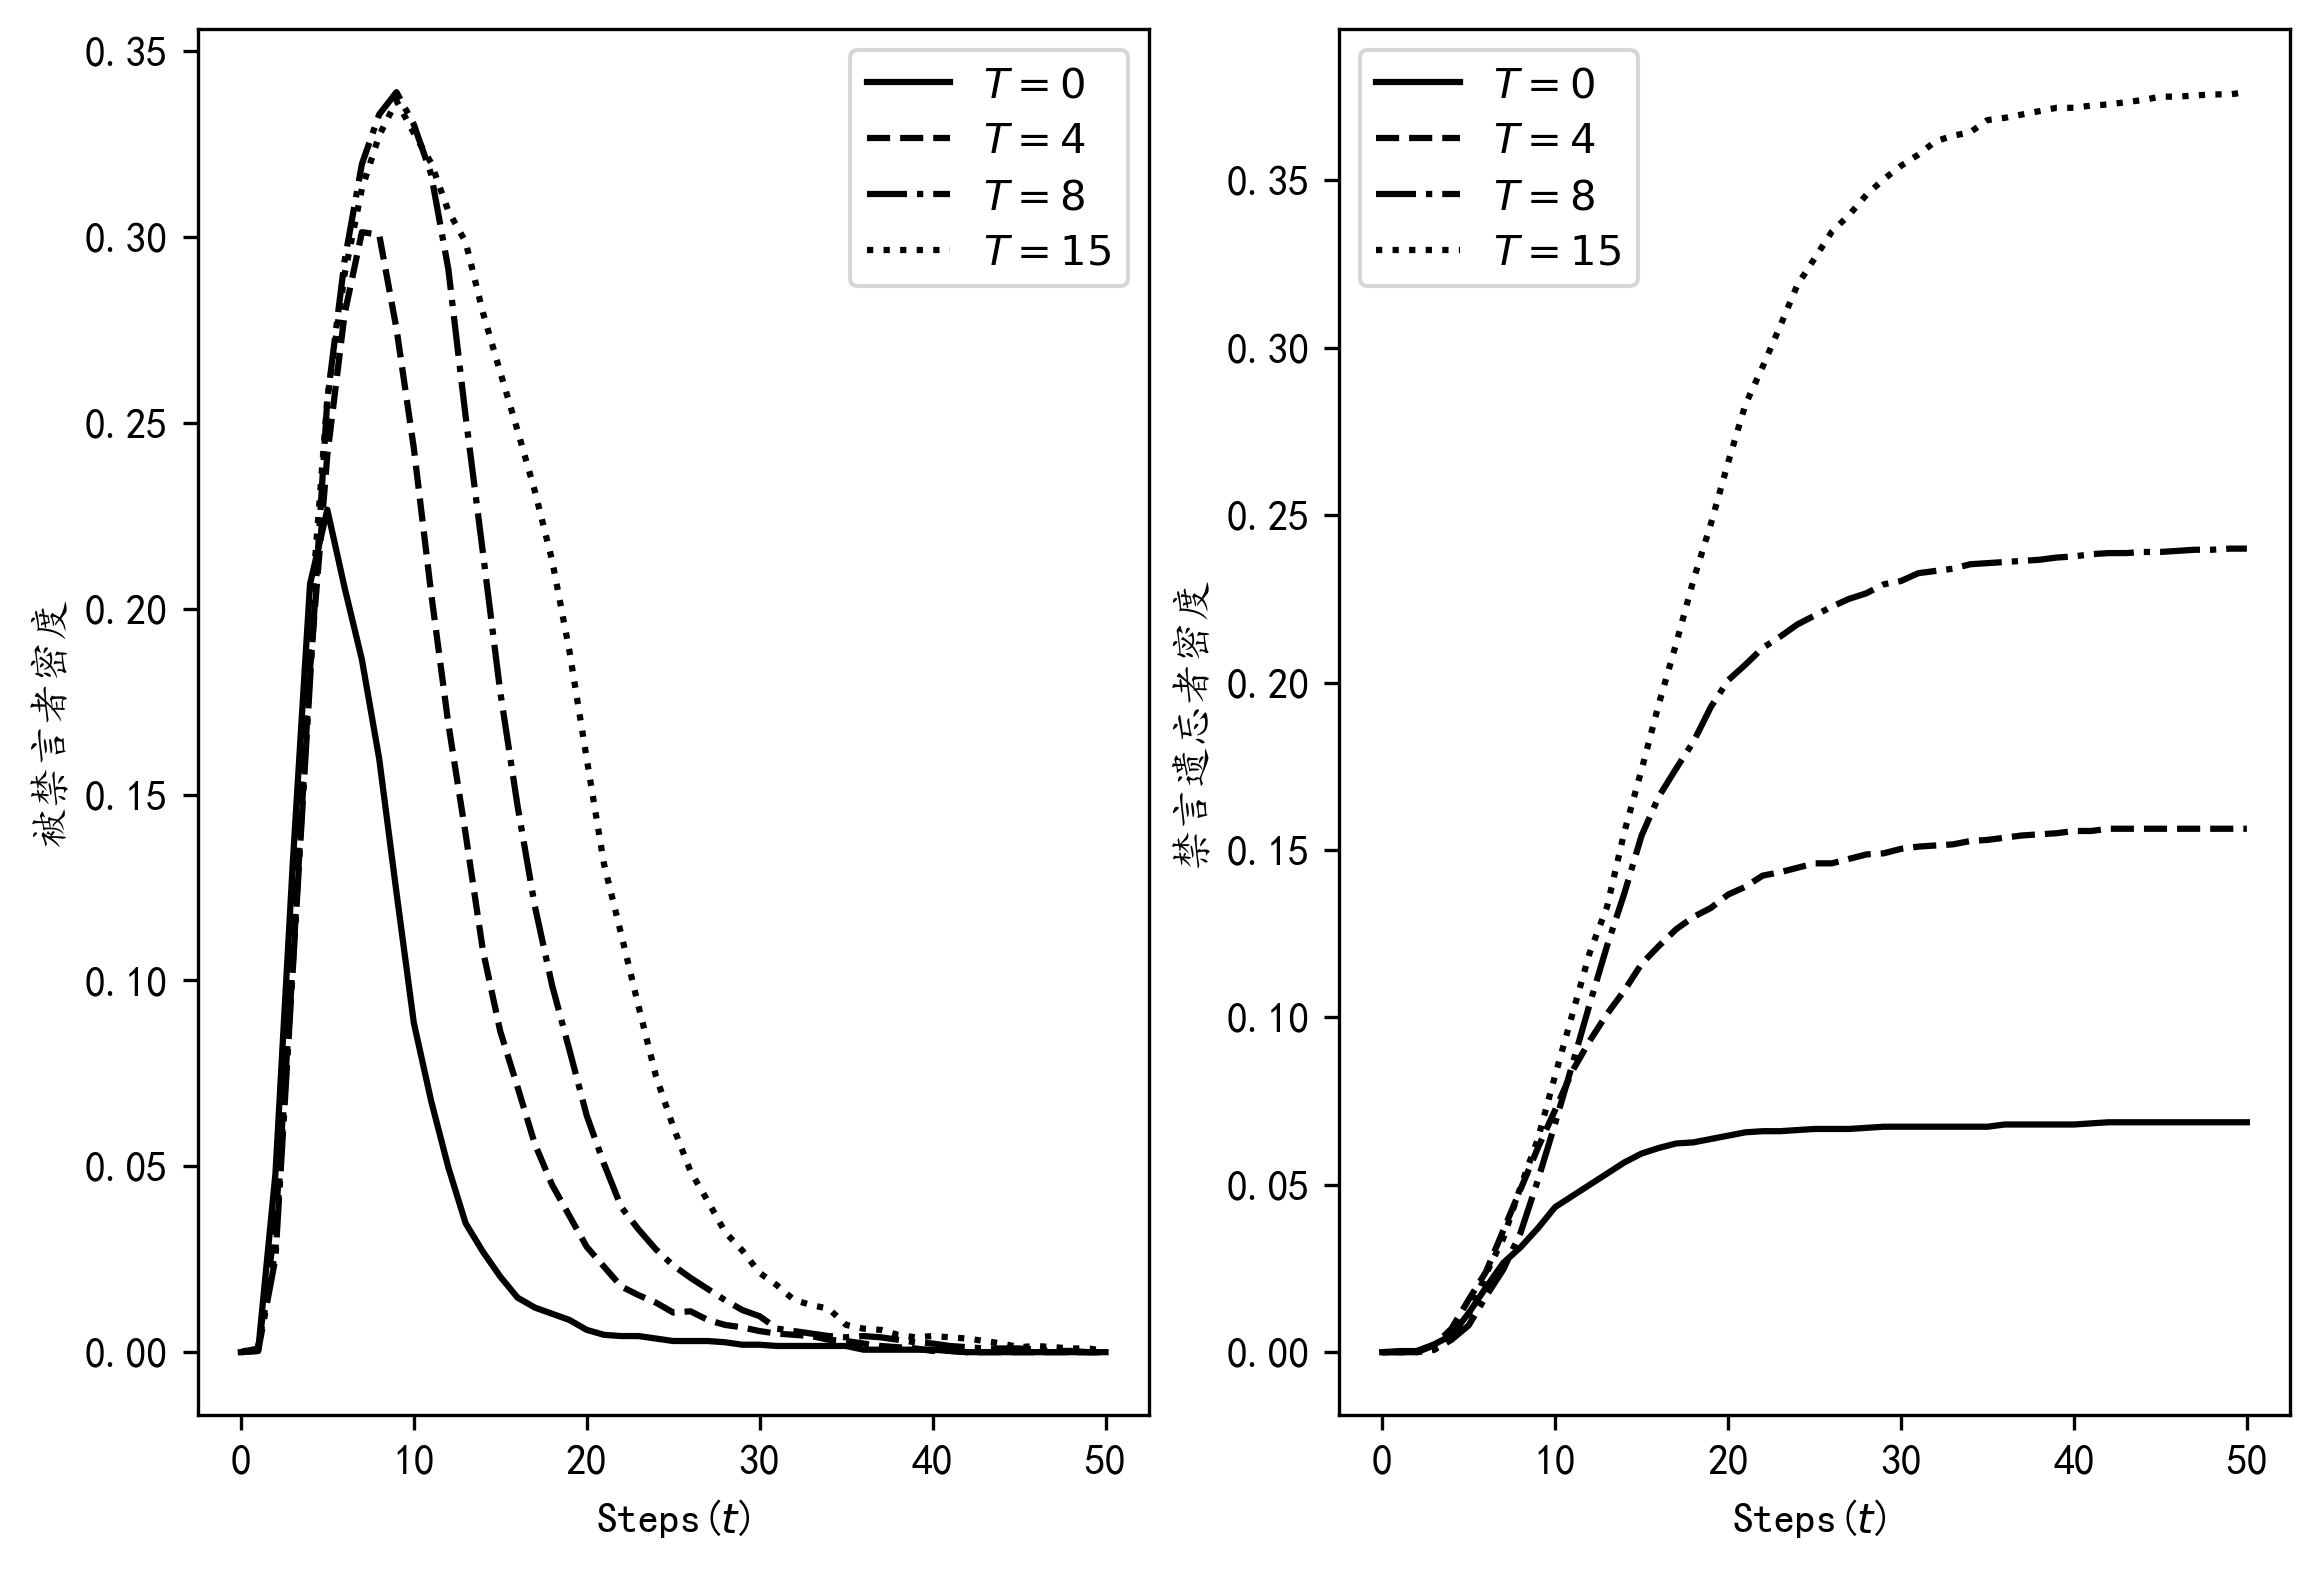

In [27]:
data=pd.read_excel("output.xlsx",sheet_name="Sheet3")
list_days=[0,2,4,6,8,10,15,20]
plt.figure(figsize=(9,6),dpi=300)
ax = plt.subplot(121)
xticks=[np.linspace(0,50,6)]
yticks=[np.linspace(0,0.9,10)]

plt.plot(range(51),data.iloc[0*5+1],color = 'k',linestyle='-',label='$T=0$')
plt.plot(range(51),data.iloc[2*5+1],color = 'k',linestyle='--',label='$T=4$')
plt.plot(range(51),data.iloc[4*5+1],color = 'k',linestyle='-.',label='$T=8$')
plt.plot(range(51),data.iloc[6*5+1],color = 'k',linestyle=':',label='$T=15$')
plt.legend()
plt.ylabel('被禁言者密度')
plt.xlabel('Steps($t$)')


ax = plt.subplot(122)
xticks=[np.linspace(0,50,6)]
yticks=[np.linspace(0,0.9,10)]

plt.plot(range(51),data.iloc[0*5+4],color = 'k',linestyle='-',label='$T=0$')
plt.plot(range(51),data.iloc[2*5+4],color = 'k',linestyle='--',label='$T=4$')
plt.plot(range(51),data.iloc[4*5+4],color = 'k',linestyle='-.',label='$T=8$')
plt.plot(range(51),data.iloc[6*5+4],color = 'k',linestyle=':',label='$T=15$')

plt.ylabel('禁言遗忘者密度')
plt.xlabel('Steps($t$) ')


plt.legend()
plt.savefig('./paper/muzzled对比图-黑白.png.png')
plt.show()

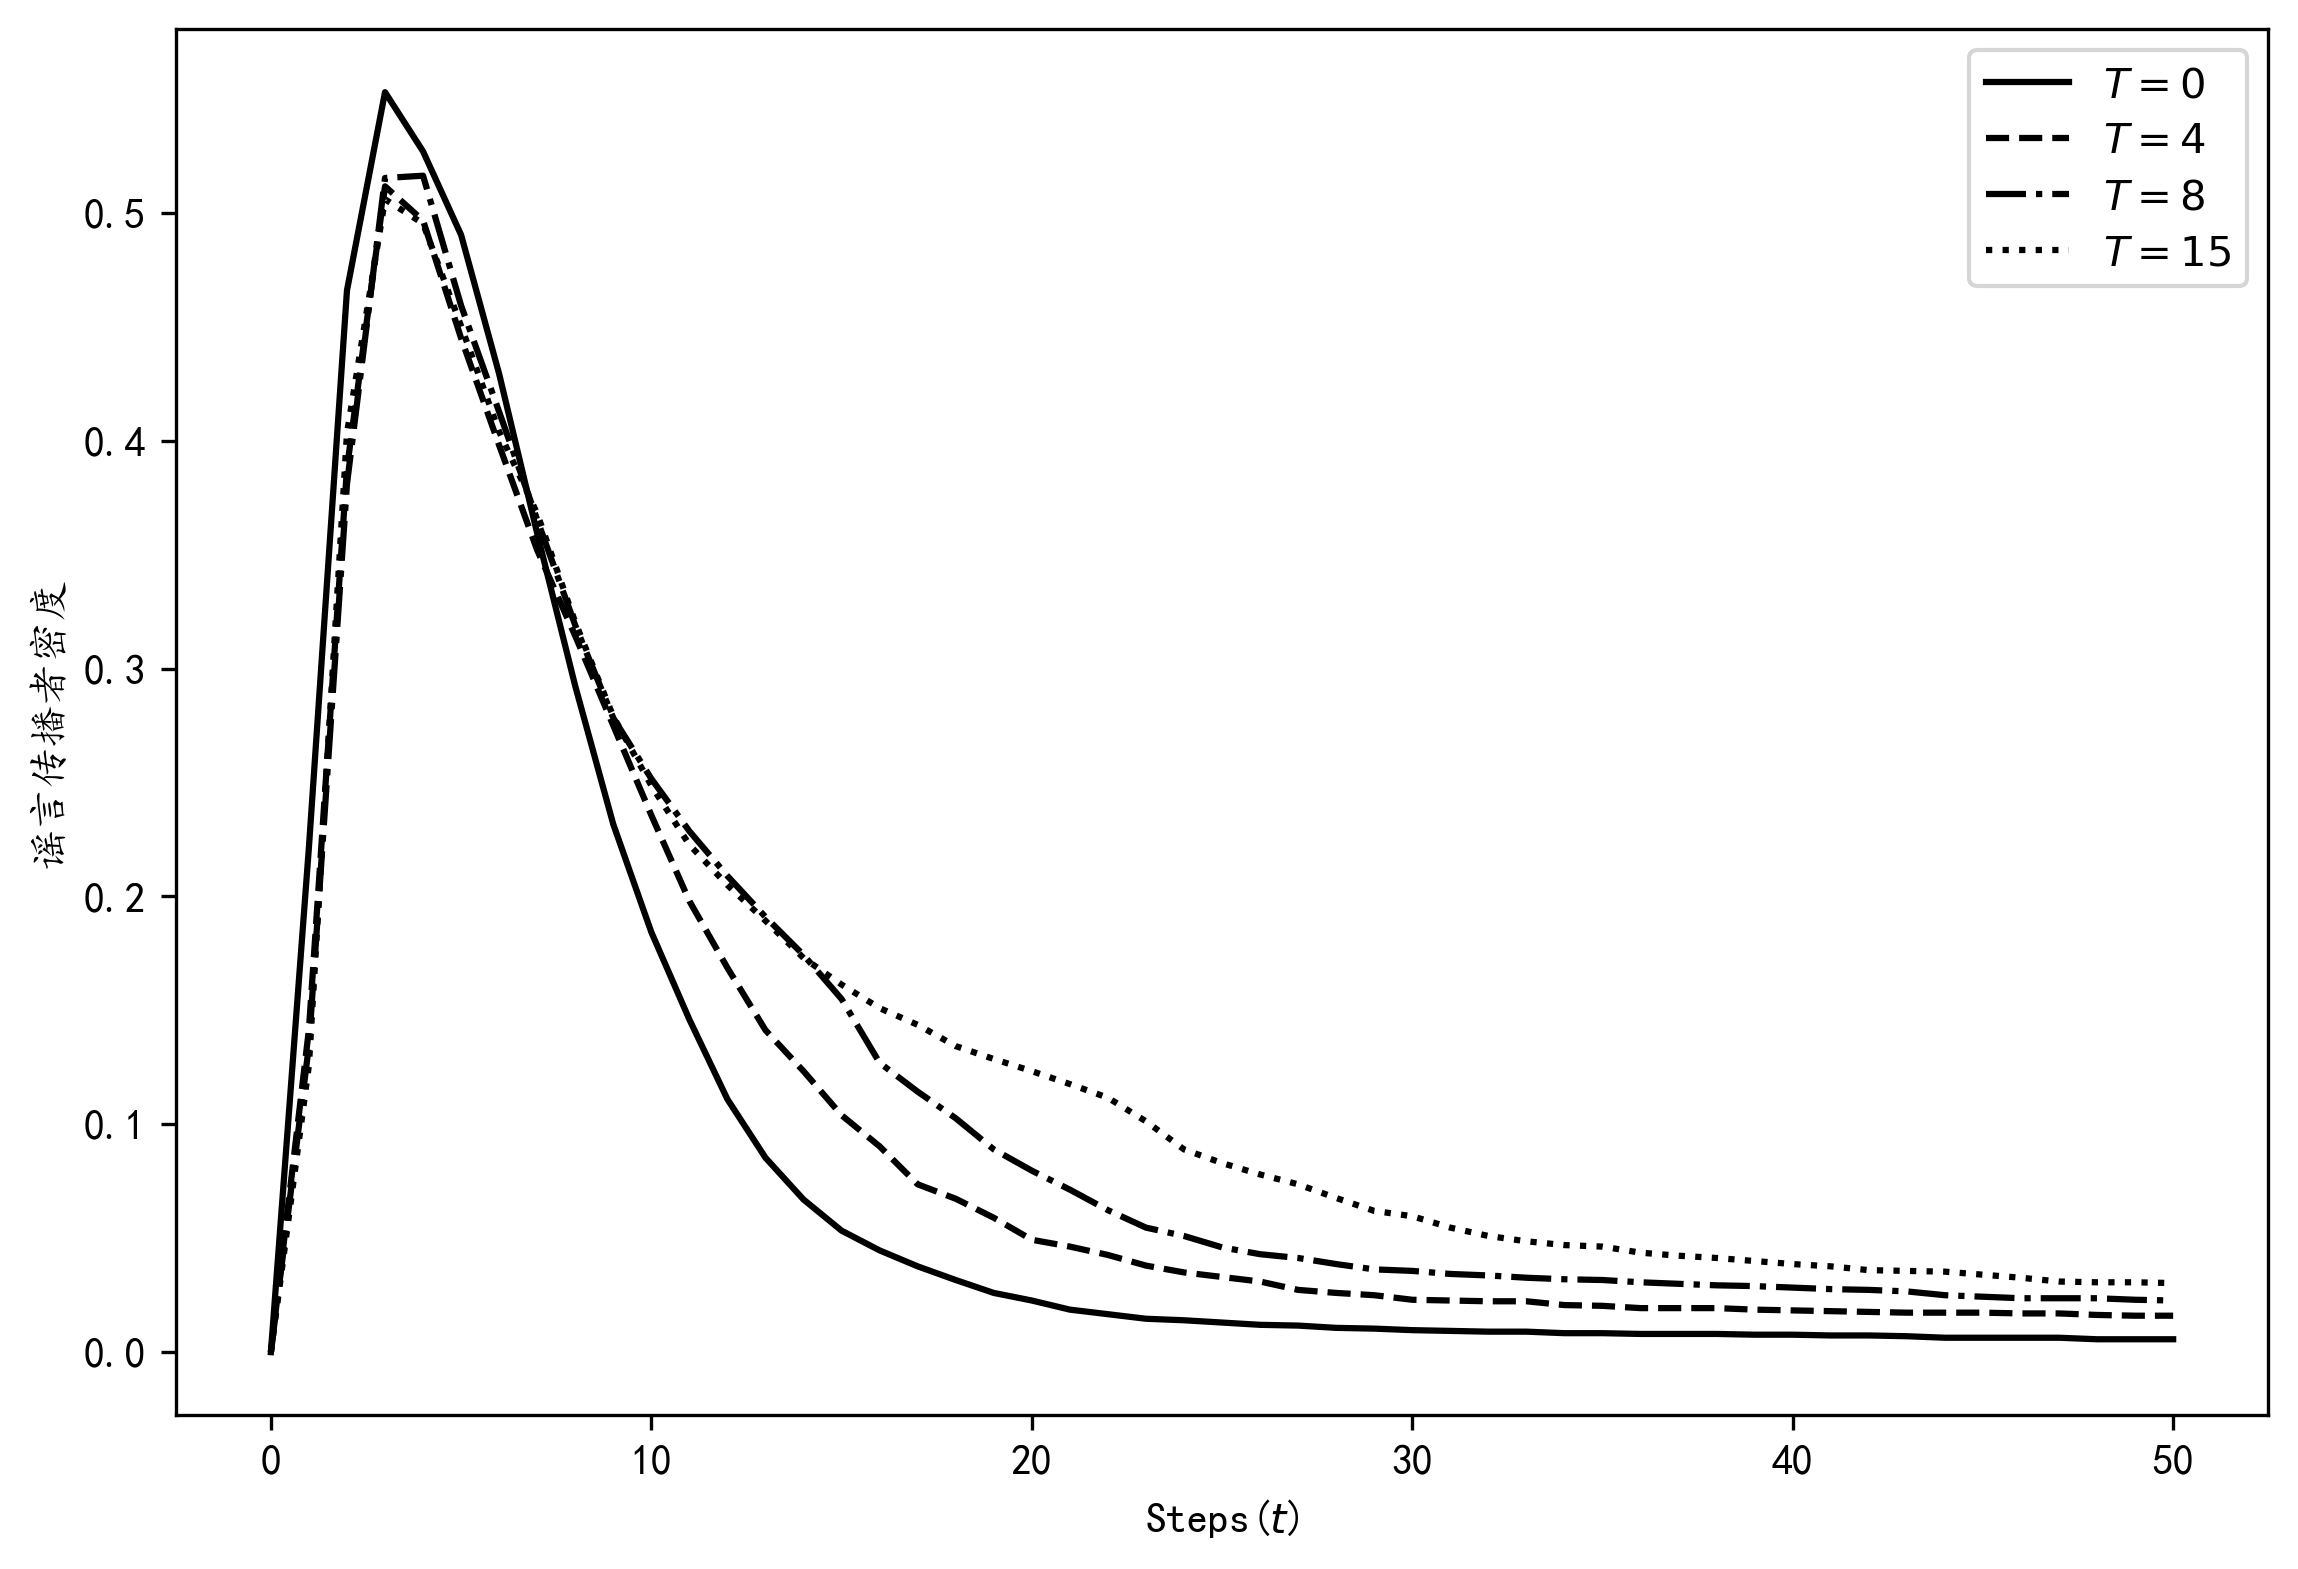

In [28]:
data=pd.read_excel("output.xlsx",sheet_name="Sheet3")

plt.figure(figsize=(9,6),dpi=300)


plt.plot(range(51),data.iloc[0*5+2],color = 'k',linestyle='-',label='$T=0$')
plt.plot(range(51),data.iloc[2*5+2],color = 'k',linestyle='--',label='$T=4$')
plt.plot(range(51),data.iloc[4*5+2],color = 'k',linestyle='-.',label='$T=8$')
plt.plot(range(51),data.iloc[6*5+2],color = 'k',linestyle=':',label='$T=15$')
plt.legend()
plt.ylabel('谣言传播者密度')
plt.xlabel('Steps($t$)')


plt.legend()
plt.savefig('./paper/rumor-黑白.png.png')
plt.show()


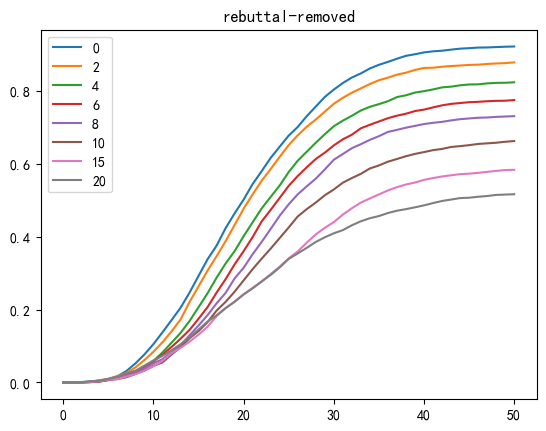

In [39]:
for i in range(len(list_days)):
    plt.plot(range(len(reslist[i*5+3])), reslist[i*5+3],label = list_days[i])
plt.legend()
plt.title('rebuttal-removed')
plt.show()

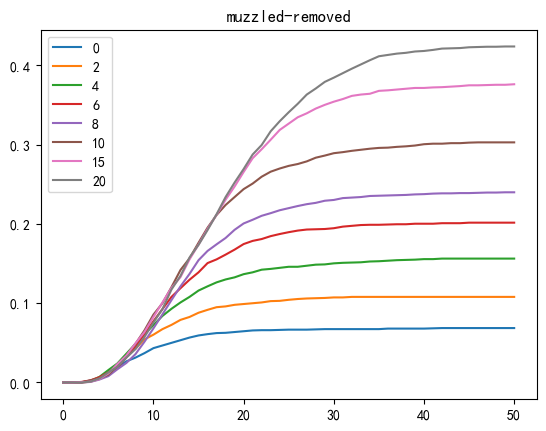

In [40]:
for i in range(len(list_days)):
    plt.plot(range(len(reslist[i*5+4])), reslist[i*5+4],label = list_days[i])
plt.legend()
plt.title('muzzled-removed')
plt.show()